# Frozen Lake Example

In [1]:
import hiive.mdptoolbox as mdptoolbox
import hiive.mdptoolbox.mdp as mdp
import hiive.mdptoolbox.example as example
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

## Helper Methods

In [2]:
#Method to generate plot for XY Data
def plot_helper(dataName, xVals,yVals, xName, yName):
    plt.plot(xVals, yVals)
    plt.ylabel(yName)
    plt.xlabel(xName)
    plt.title(dataName + ": " +  yName + " vs " + xName)
    plt.show()

In [3]:
def plot_2_helper(dataName, xVals,y1Vals, y2Vals, xName, y1Name, y2Name):
    
    # make a plot
    fig,ax = plt.subplots()
    ax.plot(xVals, y1Vals, color="red")
    ax.set_ylabel(y1Name,color="red",fontsize=14)
    
    # make a plot with different y-axis using second axis object
    ax2=ax.twinx()
    ax2.plot(xVals,y2Vals,color="blue")
    ax2.set_ylabel(y2Name,color="blue",fontsize=14)

    #Generate Plot Labels
    plt.xlabel(xName)
    y_label = y1Name + " and " + y2Name
    plot_title = dataName + "- " +  y_label + " vs " + xName
    plt.title(plot_title)
    
    #Save Plot
    save_title = 'Figures/' + plot_title + '.png'
    plt.savefig(save_title, dpi='figure', format='png')
    
    #Show Plot
    plt.show()
    
    return

In [4]:
def heat_map_helper(V):
    
    values = np.reshape(V,(8,8))
    plt.matshow(values,cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()
    
    return

In [5]:
#This Code adapted from: https://github.com/ryanym/cs7641/blob/master/assignment4/experiments.py

def build_matrix(environment, n_states, n_actions):
    """
    Convert openai discrete environment to Probability matrix and Reward matrix
    :param environment:
    :param n_states:
    :param n_actions:
    :return:Probability matrix and reward matrix
    """
    desc = np.reshape(environment.desc,64)
    reward_matrix = np.zeros((n_states, n_actions))
    probability_matrix = np.zeros((n_actions, n_states, n_states))


    for state in range(n_states):
        for action in range(n_actions):
            for data_list in environment.env.P[state][action]:
                prob, next_state, reward, done = data_list
                reward_matrix[state, action] += reward
                if desc[next_state] == b'H':
                    reward_matrix[state, action] -= 1
                probability_matrix[action, state, next_state] = prob
                probability_matrix[action, state, :] = probability_matrix[action, state, :] / \
                                                       np.sum(probability_matrix[action, state, :])

    return probability_matrix, reward_matrix

In [6]:
def run_n_avg(alg,P,R,gamma,runs):
    
    times = []
    iters =[]
    values = []
    
    for i in range(runs):
        result = alg(P,R,gamma)
        times.append(result.time)
        iters.append(result.iter)
        values.append(result.V)
    
    avg_time = np.mean(np.array(times))
    avg_iters = np.mean(np.array(iters))
    avg_values = np.average(values, axis=0)


    return avg_time, avg_iters, avg_values
        

## Generate Frozen Lake Example

In [7]:
def frozen_lake():
    
    env = gym.make('FrozenLake-v1', desc=None,map_name="8x8", is_slippery=True)
    states = env.observation_space.n
    actions = env.action_space.n
    P,R = build_matrix(env, states, actions)
    
    return P,R

## Value Iteration Functions

In [8]:
def value_iteration(P,R, gamma, verbose=False):
    
    vi = mdp.ValueIteration(P,R,gamma)
    if verbose:
        vi.setVerbose()
    results = vi.run()
    
    return vi

## Policy Iteration Functions

In [9]:
def policy_iteration(P, R, gamma, verbose=False):
    
    pi = mdp.PolicyIteration(P, R, gamma)
    if verbose:
        pi.setVerbose()
    results = pi.run()
    
    return pi

## Q-Learning

In [69]:
def q_learn(P,R,gamma, alpha=0.1, alpha_decay=0.99999, epsilon=1.0, epsilon_decay=0.001, n_iter=1000000,verbose = False):
    
    ql = mdp.QLearning(P, R, gamma,
                 alpha=alpha, alpha_decay=alpha_decay, alpha_min=0.001,
                 epsilon=epsilon, epsilon_min=0.1, epsilon_decay=epsilon_decay,
                 n_iter=n_iter, skip_check=False, iter_callback=None,
                 run_stat_frequency=None)
    
    if verbose == True:
        print("Set Verbose = True")
        ql.setVerbose()
        
    results = ql.run()
    
    return ql

In [75]:
ql = q_learn(P,R,gamma = .75, alpha=.5, alpha_decay = .99, epsilon=1.0, epsilon_decay=.75, verbose=True)

Set Verbose = True


In [76]:
np.array(ql.v_mean).shape
ql.run_stats

[{'State': 60,
  'Action': 0,
  'Reward': -2.0,
  'Error': 0.36972963764972655,
  'Time': 0.007987499237060547,
  'Alpha': 0.18486481882486328,
  'Epsilon': 0.1,
  'Gamma': 0.75,
  'Max V': 0.0,
  'Mean V': 0.0,
  'Iteration': 100},
 {'State': 34,
  'Action': 0,
  'Reward': -1.0,
  'Error': 0.06766650245351603,
  'Time': 0.015987396240234375,
  'Alpha': 0.06766650245351603,
  'Epsilon': 0.1,
  'Gamma': 0.75,
  'Max V': 0.0,
  'Mean V': -0.03199161054082076,
  'Iteration': 200},
 {'State': 23,
  'Action': 0,
  'Reward': 0.0,
  'Error': 0.0,
  'Time': 0.024072885513305664,
  'Alpha': 0.02476812831883119,
  'Epsilon': 0.1,
  'Gamma': 0.75,
  'Max V': 0.0,
  'Mean V': -0.03199161054082076,
  'Iteration': 300},
 {'State': 17,
  'Action': 0,
  'Reward': 0.0,
  'Error': 0.0,
  'Time': 0.024072885513305664,
  'Alpha': 0.009065935997497542,
  'Epsilon': 0.1,
  'Gamma': 0.75,
  'Max V': 0.0,
  'Mean V': -0.03697950028182582,
  'Iteration': 400},
 {'State': 5,
  'Action': 0,
  'Reward': 0.0,
  'E

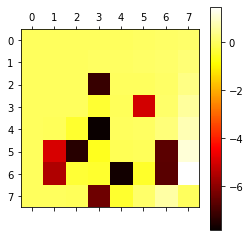

In [68]:
v = np.reshape(ql.V, (8,8))
heat_map_helper(v)

In [59]:
policy = np.reshape(ql.policy, (8,8))
policy

array([[3, 2, 2, 0, 3, 2, 1, 2],
       [3, 3, 3, 3, 3, 3, 3, 2],
       [0, 0, 0, 1, 2, 3, 2, 2],
       [0, 1, 0, 3, 0, 3, 2, 2],
       [0, 3, 0, 2, 2, 1, 3, 2],
       [0, 2, 1, 3, 3, 0, 2, 2],
       [0, 3, 2, 0, 1, 0, 3, 2],
       [0, 1, 0, 3, 1, 3, 1, 0]])

## Tests

In [11]:
def gamma_test(alg,P,R, divisions=10, runs=10):
    
    times = []
    iters = []
    discounts = []
    avg_values = []
    
    for discount in np.linspace(0.01,.99,divisions):
        #Run and Average 
        time, num_iters, avg_val = run_n_avg(alg,P,R,discount, runs)
        #append data
        discounts.append(discount)
        times.append(time)
        iters.append(num_iters)
        avg_values.append(avg_val)
    
    return discounts, times, iters, avg_values

In [12]:
def iter_v_Values(alg,P,R,gamma):
    results, stats = alg(P,R,gamma)
    iters = range(len(stats))
    iter_num = []
    max_v = []
    avg_v = []


    for i in iters:
        iter_num.append(stats[i]['Iteration'])
        max_v.append(stats[i]['Max V'])
        avg_v.append(stats[i]['Mean V'])
        
    return iter_num, max_v, avg_v

# Main

In [13]:
#Generate Frozen Lake Probability Matrix and Reward Martrix
P, R = frozen_lake()

### Gamma Tests

In [14]:
#Value Iteration Gamma Test
vi_dis, vi_times, vi_iters, vi_avg_values = gamma_test(value_iteration,P,R,divisions=100, runs=100)

In [15]:
#Policy Iteration Gamma Test
pi_dis, pi_times, pi_iters, pi_avg_values = gamma_test(policy_iteration,P,R,divisions=100,runs=100)

In [53]:
ql = q_learn(P,R,.9)

In [40]:
vi = value_iteration(P,R,.9)

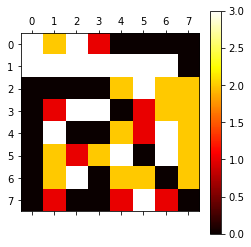

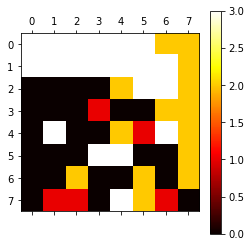

In [41]:
heat_map_helper(ql.policy)
heat_map_helper(vi.policy)

In [36]:
policy = np.reshape(ql.policy,(8,8))
policy

array([[3, 2, 3, 1, 0, 0, 0, 0],
       [3, 3, 3, 3, 3, 3, 3, 0],
       [0, 0, 0, 0, 2, 3, 2, 2],
       [0, 1, 3, 3, 0, 1, 2, 2],
       [0, 3, 0, 0, 2, 1, 3, 2],
       [0, 2, 1, 2, 3, 0, 3, 2],
       [0, 2, 3, 0, 2, 2, 0, 2],
       [0, 1, 0, 0, 1, 3, 1, 0]])

In [ ]:
range(0,len(ql.run_stats))

In [ ]:
for i in range(0,len(ql.run_stats):
    print(ql.run_stats[0]['State'])

In [ ]:
#PLot Discount v. Time and Number of Iterations
plot_2_helper("Frozen Lake Value Iteration", vi_dis,vi_times, vi_iters, "Discount", "Time", "Iterations")
plot_2_helper("Frozen Lake Policy Iteration", pi_dis,pi_times, pi_iters, "Discount", "Time", "Iterations")  

In [ ]:
gammas = [.6,.7,.8,.9]

for gamma in gammas:
    iter_num,max_v, avg_v = iter_v_Values(value_iteration,P,R,gamma)
    data_name = "Frozen Lake Value Iteration(gamma - " + str(gamma) +")"
    plot_2_helper(data_name, iter_num,max_v, avg_v, "Iteration", "Max_V", "Mean V")

In [ ]:
gammas = [.6,.7,.8,.9]

for gamma in gammas:
    iter_num,max_v, avg_v = iter_v_Values(policy_iteration,P,R,gamma)
    data_name = "Frozen Lake Policy Iteration(gamma - " + str(gamma) +")"
    plot_2_helper(data_name, iter_num,max_v, avg_v, "Iteration", "Max_V", "Mean V")

In [ ]:
vi, vi_stats = value_iteration(P,R,.4)
pi, pi_stats = policy_iteration(P,R,.4)
heat_map_helper(pi.V)
heat_map_helper(vi.V)

In [ ]:
dif = np.subtract(vi.policy, pi.policy)

print(dif.sum())
print("-----------------------------")
dif = np.subtract(vi.V,pi.V)
print(dif.sum())
